--- Fitting Prophet Model ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8mvu7if6/3dntv0pw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8mvu7if6/rjns6xc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36688', 'data', 'file=/tmp/tmp8mvu7if6/3dntv0pw.json', 'init=/tmp/tmp8mvu7if6/rjns6xc5.json', 'output', 'file=/tmp/tmp8mvu7if6/prophet_modelg4d07mal/prophet_model-20250914050707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:07:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:07:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Starting Cross-Validation ---


INFO:prophet:Making 11 forecasts with cutoffs between 2019-07-14 00:00:00 and 2024-06-17 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7b00e55c9c10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8mvu7if6/6u0hgn9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8mvu7if6/qngdb1vw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8mvu7if6/jhkl08v1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81048', 'data', 'file=/tmp/tmp8mvu7if6/6u0hgn9z.json', 'init=/tmp/tmp8mvu7if6/jhkl08v1.json', 'output', 'file=/tmp/tmp8mvu7if6/prophet_modelrpyq_5_c/prophet_model-20250914050736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:07:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8mvu7if6/mrnj5hjz.json
DE


Cross-validation performance metrics (aggregated by Prophet):
          horizon            mse        rmse         mae      mape     mdape  \
0 0 days 03:00:00   66014.864301  256.933580  216.585323  0.020946  0.018887   
1 0 days 04:00:00   71860.532038  268.068148  223.407782  0.022233  0.019331   
2 0 days 05:00:00   98388.366264  313.669199  268.673890  0.027280  0.031675   
3 0 days 06:00:00  109504.212966  330.914208  298.758051  0.031212  0.032357   
4 0 days 07:00:00  147316.255873  383.817998  338.120694  0.035895  0.032450   

      smape  coverage  
0  0.020985  1.000000  
1  0.022369  1.000000  
2  0.027292  0.960000  
3  0.031030  0.920000  
4  0.035349  0.905455  

--- Performance Metrics for Specific Horizons ---

Horizon: 1 hours
  MAE: 216.4327
  MSE: 65043.4487
  RMSE: 255.0362
  R2 Score: 0.9667
  MAPE: 1.9727%

Horizon: 6 hours
  MAE: 302.1496
  MSE: 102524.5160
  RMSE: 320.1945
  R2 Score: 0.8943
  MAPE: 3.2633%

Horizon: 12 hours
  MAE: 380.7706
  MSE: 240835.479

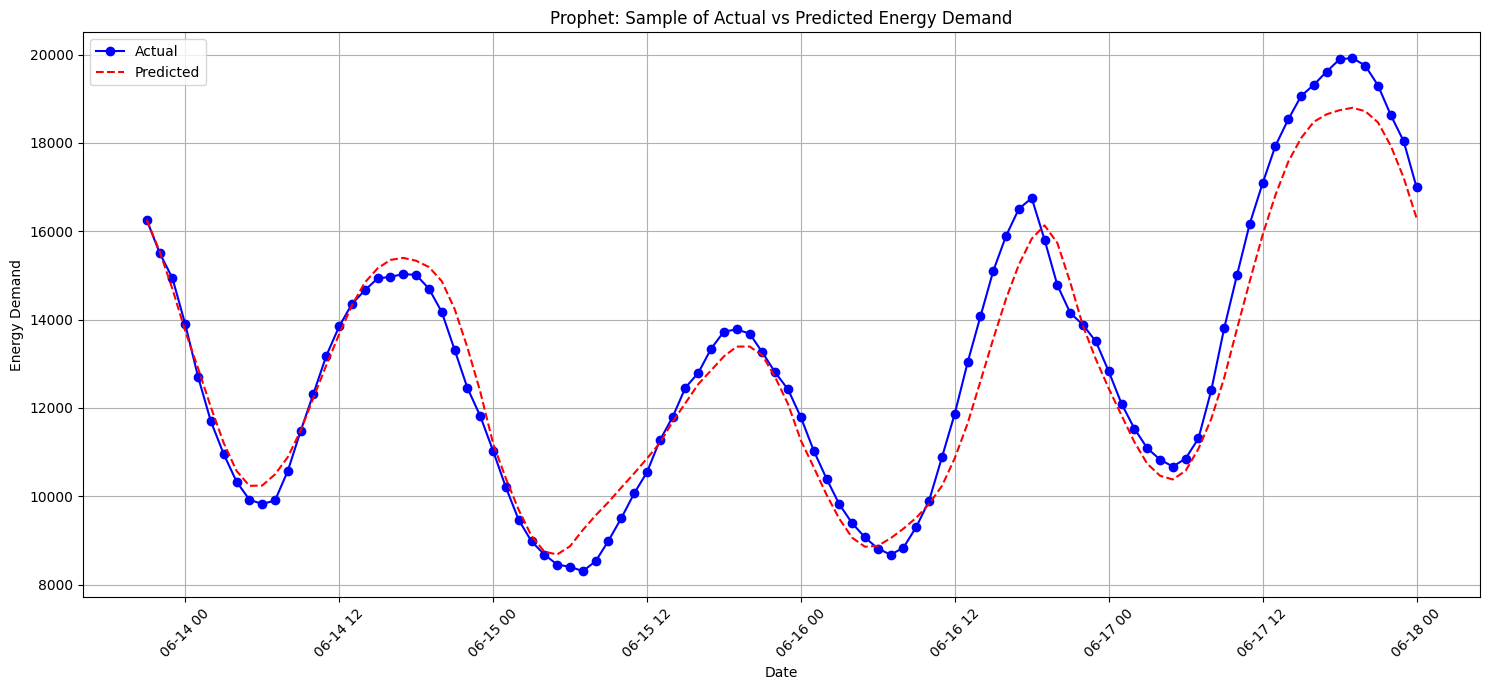


--- Plotting Prophet Components ---


KeyError: 'ds'

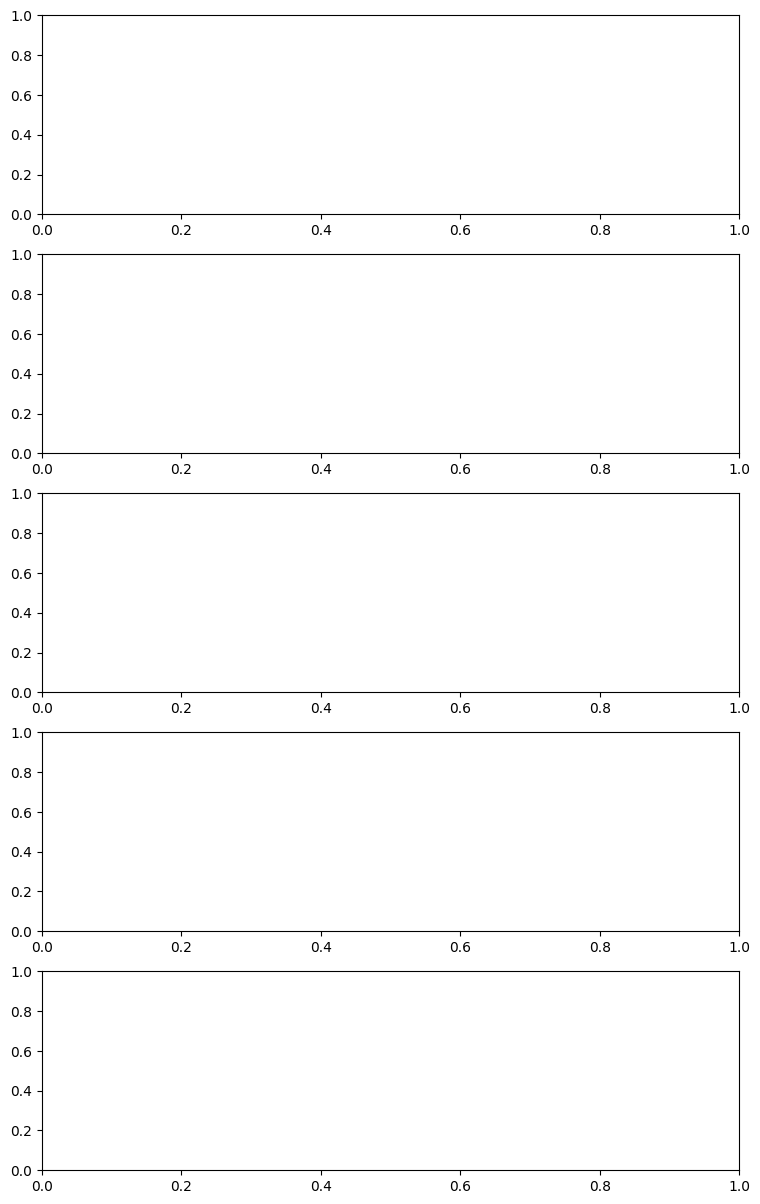

In [2]:
# Chicago Energy Demand Forecasting with Prophet (Updated & Corrected)
#
# This script uses Facebook's Prophet library for energy demand forecasting in Baltimore.
#
# Updates:
# - Corrected a KeyError by manually calculating the 'horizon' column for metric evaluation.
# - Multi-Horizon Forecasting: Cross-validation is performed with a 24-hour horizon,
#   and performance metrics are calculated for 1, 6, 12, and 24-hour ahead forecasts.
# - Additional Metrics: Evaluation now includes MAE, MSE, RMSE, R², and a robust MAPE
#   for each specific forecast horizon.

#REMOVED TEMP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- 1. Data Loading and Feature Engineering ---
# Load the dataset
# Make sure to replace 'Baltimore.xlsx' with the correct path if the file is not in the same directory.
try:
    data = pd.read_excel('Chicago.xlsx')
except FileNotFoundError:
    print("Error: 'Chicago.xlsx' not found. Please ensure the dataset is in the correct directory.")
    exit()

data.dropna(inplace=True)
data['l'] = pd.to_datetime(data['l'])
df = data.rename(columns={'l': 'ds', 'EnergyDemand': 'y'})

# Create time-based features
df['Hour'] = df['ds'].dt.hour
df['DayOfWeek'] = df['ds'].dt.dayofweek
df['Month'] = df['ds'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Create lag features
for lag in range(1, 25):
    df[f'Lag_{lag}'] = df['y'].shift(lag)

# Create interaction features
df['Temp_Humidity_Interaction'] = df['Temperature'] * df['RelativeHumidity']

df.dropna(inplace=True)

# --- 2. Prophet Model Training ---
model = Prophet()

# Add regressors
model.add_regressor('DewPoint')
model.add_regressor('WindSpeed')
model.add_regressor('Pressure')
model.add_regressor('RelativeHumidity')
model.add_regressor('Hour')
model.add_regressor('DayOfWeek')
model.add_regressor('Month')
model.add_regressor('IsWeekend')
model.add_regressor('Temp_Humidity_Interaction')

for lag in range(1, 25):
    model.add_regressor(f'Lag_{lag}')

print("--- Fitting Prophet Model ---")
model.fit(df)

# --- 3. Cross-Validation and Evaluation ---
print("\n--- Starting Cross-Validation ---")
# Perform cross-validation with a horizon that covers all our time steps
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='24 hours', parallel="processes")

# Display aggregated performance metrics from Prophet
df_p = performance_metrics(df_cv)
print("\nCross-validation performance metrics (aggregated by Prophet):")
print(df_p.head())

# Define a robust MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    if np.sum(non_zero_indices) == 0:
        return 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# Calculate and display metrics for our specific horizons
print("\n--- Performance Metrics for Specific Horizons ---")
# FIX: Calculate the 'horizon' column manually from 'ds' and 'cutoff'
df_cv['horizon'] = df_cv['ds'] - df_cv['cutoff']
df_cv['horizon_hours'] = df_cv['horizon'].dt.total_seconds() / 3600
horizons = [1, 6, 12, 24]

for h in horizons:
    df_h = df_cv[df_cv['horizon_hours'] == h]
    if not df_h.empty:
        mae = mean_absolute_error(df_h['y'], df_h['yhat'])
        mse = mean_squared_error(df_h['y'], df_h['yhat'])
        rmse = np.sqrt(mse)
        r2 = r2_score(df_h['y'], df_h['yhat'])
        mape = mean_absolute_percentage_error(df_h['y'], df_h['yhat'])

        print(f'\nHorizon: {h} hours')
        print(f'  MAE: {mae:.4f}')
        print(f'  MSE: {mse:.4f}')
        print(f'  RMSE: {rmse:.4f}')
        print(f'  R2 Score: {r2:.4f}')
        print(f'  MAPE: {mape:.4f}%')
    else:
        print(f'\nNo data for horizon: {h} hours')


# --- 4. Final Forecast and Plotting ---
print("\n--- Generating Final Forecast and Plots ---")
future = df.drop(columns=['y'])
forecast = model.predict(future)

# Join forecast with actuals for plotting
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)
aligned_df = df.join(forecast[['yhat']], how='inner')

# Plot a sample of the results
sample_period = 100
plt.figure(figsize=(15, 7))
plt.plot(aligned_df.index[-sample_period:], aligned_df['y'].iloc[-sample_period:], label='Actual', color='b', marker='o')
plt.plot(aligned_df.index[-sample_period:], aligned_df['yhat'].iloc[-sample_period:], label='Predicted', color='r', linestyle='--')
plt.title('Prophet: Sample of Actual vs Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Prophet components
print("\n--- Plotting Prophet Components ---")
fig_components = model.plot_components(forecast)
plt.show()

